# **SEISMOGRAMME (lokale und globale Erdbeben)**
Willkommen zum Jupyter-Notebook "*Seismogramme (lokale und globale Erdbeben)*" welches im Rahmen des *seismo-at-school* Projektes am Schweizerischen Erdbebendienst ([SED](http://seismo.ethz.ch/de/home/)) an der ETH Zürich in Zusammenarbeit mit der Universität Lausanne ([UNIL](https://www.unil.ch/index.html)) und dem Centre Pédagogique Prévention Séisme ([CPPS](https://www.cpps-vs.ch/home)) in Sion entwickelt wurde.

Mit Hilfe dieses Notebooks kannst Du auf die Daten der RaspberryShake Schulsensoren in der Schweiz zugreifen und Seismogramme darstellen. Dazu kannst Du entweder einzelne Parameter in dem nachfolgenden Python-Code ändern (z.B. ein Erdbeben oder einen RaspberryShake wählen) oder, falls Du schon etwas Python programmieren kannst, den Code verändern oder erweitern.

Viel Vergnügen!

---
Um den nachfolgenden Python-Code auszuführen, gehe auf die Menuleiste oben und klicke unter Menupunkt **Run** auf **Run all Cells**. Du solltest nach etwa einer Minute unterhalb der Code-Zellen Ergebnisse sehen. Einzelne Code-Zellen können auch schrittweise ausgeführt werden, um besser zu verstehen, was der Code jeweils tut. Wenn Du willst, kannst Du einzelne Parameter, wie zum Beispiel die minimale Magnitude, ändern und den Code erneut ausführen. **Klicke dazu auf die jeweilige Zelle und dann auf den Pfeil im Menu oben.**

In [35]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

import warnings
warnings.filterwarnings("ignore")
try:
    import obspy
except:
    !pip install obspy | grep -v 'already satisfied'

try:
    import cartopy
except:
    !pip install cartopy | grep -v 'already satisfied'

from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime, Stream, Trace, Stats
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Filter Parameter:
filt_type = ["teleseismic", "regional", "local", "hyperlocal"]
filt_dist = [9000, 6000, 100, 0]
filt_freqmin = [0.1, 0.7, 3.0, 3.0]
filt_freqmax = [0.8, 2.0, 8.0, 20.0]
filt_timewindow_start = [(-15 * 60), (-15 * 60), (-0.5 * 60), 0, 0]
filt_timewindow_end = [(60 * 60), (60 * 60), (5 * 60), (2 * 60), (1.5 * 60)]

# Wellengeschwindigkeiten:
vp = 5.8 # km/s P-Welle
vs = 3.4 # km/s S-Welle

# Model zur Vorhersage der theoretische Ankunftszeiten von verschiendenen seismischen Wellenphase:
model = TauPyModel(model="iasp91")

# SED Breitband-Stationen:
inv_ch = Client("ETH").get_stations(network="CH", station="*", location="--", channel="HH*", level="RESP")
inv_ch = inv_ch.select(channel="*Z", station="*", time=obspy.UTCDateTime("2050-01-01T01:00:00.000Z"))

# Seismo-at-school RaspberryShake Stationen:
inv_s = Client("ETH").get_stations(network="S", station="*",location="--", channel="EH*", level="RESP")
inv_s = inv_s.select(channel="*Z", station="*", time=obspy.UTCDateTime("2050-01-01T01:00:00.000Z"))

print("Ich habe " + str(len(inv_ch[0])) + " SED Breitband-Stationen und " + str(len(inv_s[0])) + " Seismo-at-school RaspberryShake Stationen in der Schweiz gefunden.")
# All seismo-at-school RaspberryShake in Switzerland:
print(inv_s[0])

Ich habe 70 SED Breitband-Stationen und 24 Seismo-at-school RaspberryShake Stationen in der Schweiz gefunden.
Network S (Seismology at School Program)
	Station Count: None/None (Selected/Total)
	2008-01-01T00:00:00.000000Z - --
	Access: open
	Contains:
		Stations (24):
			S.COAVI (Val d'Anniviers, College, VS)
			S.COAYT (Ayent, College, VS)
			S.COLEY (Leytron, College, VS)
			S.COORS (Orsières, College, VS)
			S.COSAV (Saviese, College, VS)
			S.COSTG (St-Guérin, College, VS)
			S.CPPSS (Sion, CPPS HES-SO, VS)
			S.EAMCX (L'Arpille, VS)
			S.EDILA (Lausanne, Eidgenössisches Departement des Innern (EDI), VD)
			S.GLSTL (Liestal, Gymnasium Liestal, BL)
			S.GOBZL (Langenthal, Gymnasium Oberaargau (Bildungszentrum Langenthal), BE)
			S.GUSTZ (Zürich, Gymnasium Unterstrass)
			S.KKNZH (Küsnacht, Kantonsschule, ZH)
			S.KSCHR (Chur, Bündner Kantonsschule, GR)
			S.KSHOZ (Zürich, Kantonsschule Hottingen, ZH)
			S.KSKNZ (Küsnacht, Kantonsschule, ZH)
			S.KSROM (Romanshorn, Kantonsschule, TG


**SCHRITT 1: Suche im Erdbeben-Katalog nach lokalen Erdbeben in der Schweiz**

Selbst Erdbeben in sehr grosser Entfernung, z.B. in Japan, können in der Schweiz gemessen werden, wenn sie stark genug sind. Je nach Entfernung zwischen dem Erdbeben und der Erdbebenstation unterscheidet man zwischen lokalen und globalen Erdbeben. Lokale Erdbeben sind bis zu etwa 200 km entfernt, globale Erdbeben haben grössere Entfernungen. Erdbeben in der Schweiz und im grenznahen Ausland sind aus Sicht des schweizerischen Netzwerkes lokal.

Starte mit einer Suche nach einem lokalen Erdbeben in der Schweiz (oder grenznahmen Ausland). Wähle dazu in der nächsten Code-Zelle unterhalb dieses Textes ein beliebiges Jahr (*year*), eine minimale Mangitude (*minmag*) und eine maximale Magnitude (*maxmag*) für Deine Erdbebensuche aus. Achtung: Je kleiner *minmag*, desto längert dauert die Suche.

Beispiel:

**year   = 2024**

**minmag = 2.5**

**maxmag = 6.0**

Entferne "#" am Zeilenanfang, um den entsprechenden Parameter zu aktivieren.

In [36]:
# Diese Parameter kannst Du ändern:
# Entferne "#" am Zeilenanfang, um den entsprechenden Parameter zu aktivieren

# 1. Suche nach lokalen Erdeben in der Schweiz:
type = "local"  # type = "local"
year   = 2024   # Wähle ein beliebiges Jahr für Deine Erdbeben-Suche (z.B. year = 2024)
minmag = 2.5    # Wähle die kleinste Magnitude für Deine Erdbeben-Suche (z.B. minmag = 2.5)
maxmag = 6.0    # Wähle die grösste Magnitude für Deine Erdbeben-Suche (z.B. maxmag = 6.0)

# 2. Suche nach globalen Erdbeben irgendwo auf der Welt:
#type = "global" # type = "global"
#year   = 2024   # Wähle ein beliebiges Jahr für Deine Erdbeben-Suche (z.B. year = 2024)
#minmag = 7.0    # Wähle die kleinste Magnitude für Deine Erdbeben-Suche (z.B. minmag = 7.0)
#maxmag = 8.0    # Wähle die grösste Magnitude für Deine Erdbeben-Suche (z.B. maxmag = 8.0)

Starte nun Deine Katalog-Suche, indem Du den Code in der nächsten Zelle ausführst.

In [37]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:


# local configuration
if type == "local":
  server = "ETH"
# global configuration
else:
  server = "IRIS"

try:
    cat = Client(server).get_events(minmag=minmag, maxmag=maxmag, starttime=obspy.UTCDateTime(str(year) + "-01-01T00:00"), endtime=obspy.UTCDateTime(str(year+1) + "-01-01T00:00"))
    print("Ich habe " + str(len(cat)) +" Erdbeben mit einer Magnitude zwischen " +str(minmag)+ " bis " +str(maxmag)+ " im Jahr " +str(year)+ " gefunden.")
    print(cat.__str__(print_all=True))
except:
  print("Ich habe keine Erdbeben für Deine Suchanfrage gefunden. ändere Deine Parameter und versuche es noch einmal.")

Ich habe 18 Erdbeben mit einer Magnitude zwischen 2.5 bis 6.0 im Jahr 2024 gefunden.
18 Event(s) in Catalog:
2024-04-22T01:35:55.193885Z | +46.837,   +6.741 | 3.78 MLhc | manual
2024-04-17T20:28:16.868709Z | +47.758,   +8.923 | 2.93 MLhc | manual
2024-04-17T03:51:14.916189Z | +47.767,   +7.407 | 2.73 MLhc | manual
2024-04-14T04:56:01.290185Z | +46.384,   +9.873 | 2.54 MLhc | manual
2024-03-27T14:45:57.606671Z | +45.973,   +7.961 | 2.60 MLhc | manual
2024-03-22T05:31:55.341004Z | +48.202,   +8.981 | 2.79 MLhc | manual
2024-03-18T15:52:47.700583Z | +46.397,   +8.538 | 3.10 MLhc | manual
2024-03-15T05:19:33.527874Z | +46.369,   +6.994 | 2.61 MLhc | manual
2024-02-27T01:21:42.685602Z | +47.366,   +6.913 | 3.44 MLhc | manual
2024-02-10T23:14:40.409448Z | +47.647,   +6.336 | 3.41 MLhc | manual
2024-02-07T23:40:10.780252Z | +46.017,   +6.613 | 2.64 MLhc | manual
2024-02-03T06:29:10.401621Z | +47.660,   +6.310 | 2.88 MLhc | manual
2024-01-26T23:06:45.139208Z | +47.349,  +10.859 | 3.70 MLhc | m

**SCHRITT 2: Wähle ein Erdbeben aus dem Erdbebenkatalog aus**

Wähle nun ein Erdbeben aus Deiner vorherigen Suche aus, indem für dieses Beben die Herdzeit in der linken Spalte, also die Zeit zu der sich das Erdbeben ereignet hat, in die nächste Zelle überträgst.

Beispiel: **origin_time=obspy.UTCDateTime("2024-02-27T01:21:42.685602Z")**

In [38]:
# Diesen Parameter kannst Du ändern:

origin_time=cat[0].origins[0].time

# Beispiele lokale Erdbeben:
#origin_time=obspy.UTCDateTime("2024-02-27T01:21:42.685602Z")  # M3.4 Jura
#origin_time=obspy.UTCDateTime("2024-04-22T01:35:55.246216Z")  # M3.8
#origin_time=obspy.UTCDateTime("2017-07-01T08:10:34.076731Z")  # M4.3 Lintal?
#origin_time=obspy.UTCDateTime("2024-04-17T03:51:14.916189Z")  # M2.9 Mulhouse
#origin_time=obspy.UTCDateTime("2024-03-27T21:19:37.332000Z")  # M4.4 Italy
#origin_time=obspy.UTCDateTime("2024-03-18T15:52:47.694063Z")  # M3.1 Bosco/Gurin TI
#origin_time=obspy.UTCDateTime("2024-03-15T05:19:33.541611Z")  # M2.6 Montreux

# Beispiele globale Erdbeben:
#origin_time=obspy.UTCDateTime("2024-04-02T23:58:11.228000Z")  # M7.4  Taiwan
#origin_time=obspy.UTCDateTime("2024-01-01T07:10:09.474000Z")  # M7.5 Japan


Suche nun nach weiteren Informationen zu dem Erdbeben, indem Du in Code in der nächsten Zelle ausführst.

Das Erdbeben ereignete sich an Länge = 46.83715379 Grad und Breite = 6.741095415 Grad. Es hatte eine Tiefe von 2.165527344 km und eine Magnitude von 3.783988693.


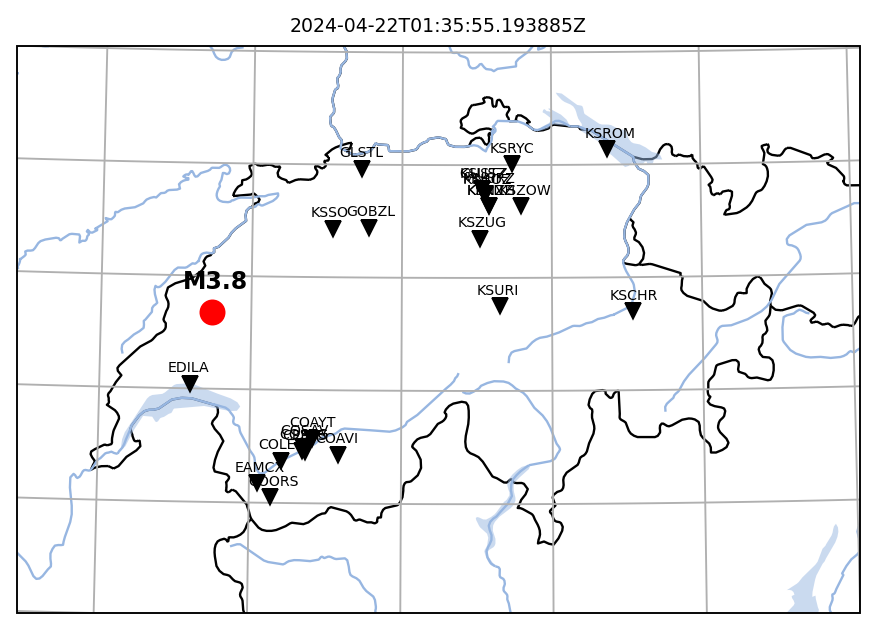

In [39]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

# Catalog search
try:
  cat = Client(server).get_events(minmag=minmag, starttime=obspy.UTCDateTime(origin_time-5), endtime=obspy.UTCDateTime(origin_time+5))
  eq_lat = cat[0].origins[0].latitude
  eq_lon = cat[0].origins[0].longitude
  eq_depth = cat[0].origins[0].depth/1000
  eq_mag = cat[0].magnitudes[0].mag
  print("Das Erdbeben ereignete sich an Länge = " +str(eq_lat) +
        " Grad und Breite = " + str(eq_lon) + " Grad. Es hatte eine Tiefe von " + str(eq_depth) + " km und eine Magnitude von " +str(eq_mag) +".")
except:
  print("Ich habe kein Beben finden können. Probiere es noch einmal mit einer anderen Herdzeit.")


# Plot map:
# Set up a figure
fig = plt.figure(dpi=170)
if type=="local":
    # Set up a custom projection
    projection = ccrs.AlbersEqualArea(
        central_longitude=8.5,
        central_latitude=46.5,
    )
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent((5.5, 11., 45.5, 48))
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
else:
    #Set up a custom projection
    projection = ccrs.PlateCarree()
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent((-180, 180., -90, 90))
    ax.stock_img()

# Draw standard features
ax.gridlines()
ax.coastlines()
ax.set_title(origin_time,fontsize=8)

for inv in inv_s[0]:
    plt.plot(inv.longitude,inv.latitude,'kv',markersize=6,transform=ccrs.Geodetic())
    if type=="local":
        plt.text(inv.longitude-0.15,inv.latitude+0.05,inv.code,size=6,transform=ccrs.Geodetic())
plt.plot(eq_lon,eq_lat,'ro',markersize=10, transform=ccrs.Geodetic())
plt.text(eq_lon-0.2,eq_lat+0.1,'M'+str(round(eq_mag*10)/10), fontweight="bold", transform=ccrs.Geodetic())
plt.show()



**SCHRITT 3: Wähle einen RaspberryShake aus und erstelle das Seismogramm**

Wähle nun aus der nachfolgenden Liste einen RaspberryShake aus, der Dich interessiert. Entferne dazu einfach "#" am Zeilenanfang.

Beispiel: **rs_station = ["KSSO", "RFE6B", "MOUTI"]**. In diesem Beispiel heisst der RaspberryShake innerhalb des SED Netzwerkes "KSSO". Auf der RaspberryShake Webpage findest Du diesen Sensor unter dem Namen "RFE6B". Die nächste professionelle Breitbandstation im SED Netzwerk heisst "MOUTI".

In [40]:
# Diesen Parameter kannst Du ändern:

# 3D RaspberryShake Schul-Seismometer in der deutschsprachigen Schweiz:
rs_station = ["KSSO","RFE6B", "MOUTI"]      # KS Solothurn
#rs_station = ["MNGRZ","R7DBB", "ZUR"]      # MNG Rämibühl
#rs_station = ["KSZUG","R3BE0", "ZUR"]      # KS Zug
#rs_station = ["KSCHR","RB22F", "PLONS"]    # Bündner KS Chur
#rs_station = ["KSRYC","RF726", "WILA"]     # KS Rychenberg Winterthur
#rs_station = ["KSKNZ","RC23B", "ZUR"]      # KS Küsnacht
#rs_station = ["KSHOZ","RE5E7", "ZUR"]      # KS Hottingen Zürich
#rs_station = ["KSURI","R8F49", "MUO"]      # KS Uri
#rs_station = ["KSROM","R58D2", "WALHA"]    # KS Romanshorn
#rs_station = ["KSZOW","RF726", "WILA"]     # KS Zürcher Oberland, Wetzikon
#rs_station = ["GUSTZ","R4335", "ZUR"]      # Gymnasium Unterstrass
#rs_station = ["GOBZL","R19BB", "BALST"]    # Gymnasium Oberaargau
#rs_station = ["GLSTL","RDFB5", "MUTEZ"]    # Gymnasium Liestal
#rs_station = ["GBIEL","R8C09"]             # OFFLINE Gymnasium Biel-Seeland Biel
#rs_station = ["KSENZ","RD3C4"]             # OFFLINE Kantonsschule Enge Zürich
#rs_station = ["KSOBW","RDFB5"]             # OFFLINE Gymnasium Oberwil

# ==========================================================
# 1D RaspberryShake in der Romandie:
#rs_station = ["ESNYM","R5D35"]  # OFFLINE ES Nyon-Marens
#rs_station = ["EPSBE","R65E9"]  # OFFLINE EPS de Begnins – L'Esplanade
#rs_station = ["ESLAS","R8E4D"]  # OFFLINE ES de La Sarraz et environs
#rs_station = ["EPSGD","R3B57"]  # EPS Grandson -- NO DATA?
#rs_station = ["ESTSE","R52F7"]  # OFFLINE ES des Trois-Sapins
#rs_station = ["ESPEC","R46E5"]  # OFFLINE ES du Pays-d'Enhaut
#rs_station = ["EPSOL","RE4DE"]  # OFFLINE EPS Les Ormonts-Leysin
#rs_station = ["EPSVP","RF727"]  # OFFLINE EPSCL Collège du Verney
#rs_station = ["EPSLE","R5BF0"]  # OFFLINE Collège/EPS de l'Elysée
#rs_station = ["EPSLB","R0CD2"]  # OFFLINE EPS Bergières
#rs_station = ["EDILA","RC676"]  # partner institution (EDI LAUSANNE)
#rs_station = ["CLREN","R3BDC"]  # OFFLINE Collège du Léman
#rs_station = ["EPSEC","R8710"]  # OFFLINE EPS Ecublens
#rs_station = ["ESSTI","R1F5E"]  # OFFLINE ES St-Imier
#rs_station = ["COPCM","RA83F"]  # OFFLINE CO des Perraires
#rs_station = ["EAMCX","S7A06"]  # Ecole de l'Arpille
#rs_station = ["COORS","S3900"]  # CO Orsières
#rs_station = ["COLEY","RA7C7"]  # CO Leytron
#rs_station = ["COHEU","RB289"]  # CO Hérens -- NO DATA?
#rs_station = ["COAVI","RA652"]  # CO d'Anniviers
#rs_station = ["COLSL","RE4EF"]  # OFFLINE CO des Liddes
#rs_station = ["COAYT","RB15C"]  # CO Ayent -- NO DATA?
#rs_station = ["COSAV","R2D50"]  # CO Savièse -- NO DATA?
#rs_station = ["COSTG","R7694"]  # CO St-Guérin
#rs_station = ["CPPSS","R05D6"]  # partner institution (SION CPPS HES-SO)

Führe nun den Code in der nächsten Zelle aus, um das Seismogramm darzustellen.

KSSO ist 73.7 km von dem Erdbeben entfernt.
Die P-Wellen (roter Strich) erreichen die Station nach 12.7 Sekunden, die S-Wellen (blauer Strich) nach 22.0 Sekunden.
Falls Du keine Einsätze erkennen kannst, sind die Erschütterungen an der Station vermutlich zu gering.
Versuche es noch einmal mit einem stärkeren oder näheren Erdbeben.
Die Daten wurden von 3.0 Hertz (Hz) bis 20.0 Hertz (Hz) gefiltert.


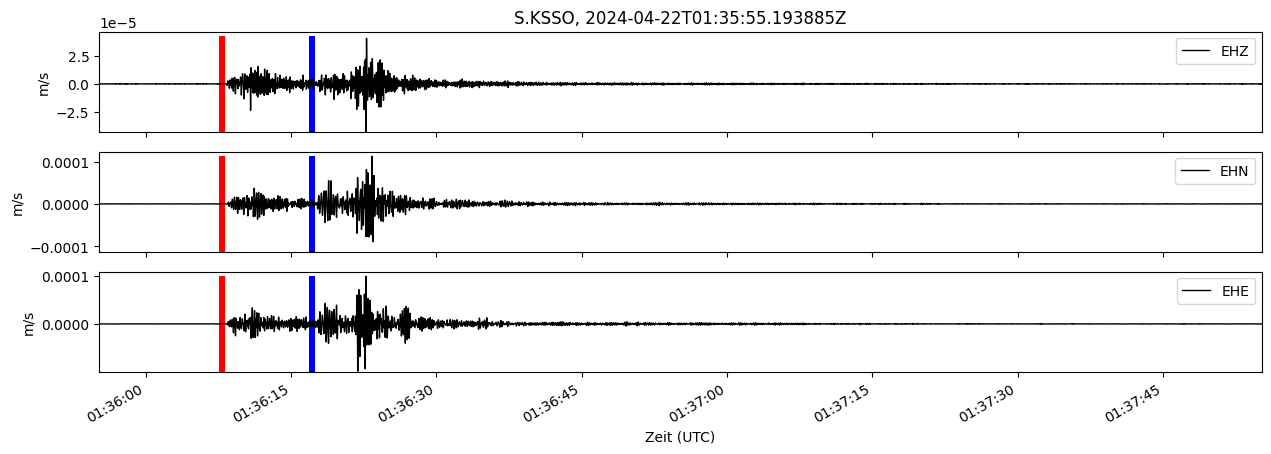

In [41]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:



try:
  try:
    inv_rs = Client("ETH").get_stations(network="S", station=rs_station[0],
                                        location="--", channel="EH*", level="RESP",
                                        starttime=origin_time, endtime=origin_time+24*60*60)
  except:
    inv_rs= Client("RASPISHAKE").get_stations(network="AM", station=rs_station[1],
                                        location="00", channel="EH*", level="RESP",
                                              starttime=origin_time, endtime=origin_time+24*60*60)
  sta_lat = inv_rs[0][0].latitude
  sta_lon = inv_rs[0][0].longitude
  epi_dist = gps2dist_azimuth(eq_lat, eq_lon, sta_lat, sta_lon)[0]/1000
  if epi_dist <=110:
    phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist/111.111,phase_list=["p","s"])
    p_arr = phase_arrivals[0].time
    s_arr = phase_arrivals[1].time
  elif not model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist/111.111,phase_list=["P"]) == []:
    phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist/111.111,phase_list=["P"])
    p_arr = phase_arrivals[0].time
    phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist/111.111,phase_list=["S"])
    s_arr = phase_arrivals[0].time

  else:
    phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist/111.111)
    p_arr = phase_arrivals[0].time
    s_arr = []


  if epi_dist >= filt_dist[0]:
    idx = 0
  elif epi_dist >= filt_dist[1]:
    idx = 1
  elif epi_dist >= filt_dist[2]:
    idx = 2
  elif epi_dist >= filt_dist[3]:
    idx = 3

  eq_type = filt_type[idx]
  freqmin = filt_freqmin[idx]
  freqmax = filt_freqmax[idx]
  timewindow_start = origin_time + filt_timewindow_start[idx]
  timewindow_end = origin_time + filt_timewindow_end[idx]
  if idx < 3:
    timewindow_start +=  p_arr
    timewindow_end +=  p_arr
  print(rs_station[0] + " ist " + str(round(epi_dist*10)/10) + " km von dem Erdbeben entfernt.")

  try:
    stream = Client("ETH").get_waveforms(network="S", station=rs_station[0],
                                         location="--", channel="EH*", starttime=timewindow_start - 60,
                                         endtime=timewindow_end + 60, attach_response=True)
  except:
    stream = Client("RASPISHAKE").get_waveforms(network="AM", station=rs_station[1],
                                                location="00", channel="EH*", starttime=timewindow_start - 60,
                                                endtime=timewindow_end + 60, attach_response=True)
  stream.merge(method=0, fill_value='interpolate')
  stream.detrend()
  stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
  stream.remove_response(output='VEL')
  stream.trim(starttime = timewindow_start, endtime = timewindow_end)

  fig = plt.figure()
  for idx, trace in enumerate(stream):
    if trace.stats.channel == "EHZ":
      ax = fig.add_subplot(len(stream),1,1)
      plt.title("S." + rs_station[0] + ", " + str(cat[0].origins[0].time))
    elif trace.stats.channel == "EHN":
      ax = fig.add_subplot(len(stream),1,2)
    else:
      ax = fig.add_subplot(len(stream),1,3)
    ax.xaxis_date()
    ax.plot(trace.times("matplotlib"), trace.data, "k-", linewidth = 1, label = trace.stats.channel)
    plt.bar(origin_time + p_arr, height =  2 * np.abs(trace.max()), bottom = -np.abs(trace.max()),
            width = (timewindow_end-timewindow_start)/200, align = "center", color = "r")
    if not s_arr == []:
      plt.bar(origin_time + s_arr, height = 2 * np.abs(trace.max()), bottom = -np.abs(trace.max()),
              width = (timewindow_end-timewindow_start)/200, align = "center", color = "b")
    plt.xlim(timewindow_start, timewindow_end)
    plt.xlabel('Zeit (UTC)')
    plt.ylabel('m/s')
    plt.legend()
    fig.autofmt_xdate()

  fig.set_figheight(5)
  fig.set_figwidth(15)

  print("Die P-Wellen (roter Strich) erreichen die Station nach " + str(round(p_arr*10)/10) +
        " Sekunden, die S-Wellen (blauer Strich) nach "+ str(round(s_arr*10)/10) + " Sekunden.")
  print("Falls Du keine Einsätze erkennen kannst, sind die Erschütterungen an der Station vermutlich zu gering.")
  print("Versuche es noch einmal mit einem stärkeren oder näheren Erdbeben.")
  print("Die Daten wurden von " +str(freqmin) + " Hertz (Hz) bis " +str(freqmax) + " Hertz (Hz) gefiltert.")

except:
  print(" ")
  print("Ich habe keine Daten für " + rs_station[0] + " gefunden. Versuche es noch einmal.")

Vergleiche nun das Seismogramm von dem seismo-at-school RaspberryShake mit dem an der nächstgelegenen SED Breitband-Station, indem Du den Code in der nächsten Zelle ausführst.

Die nächste Breitband-Station ist CH.MOUTI. Sie ist 17.7 km von KSSO entfernt.


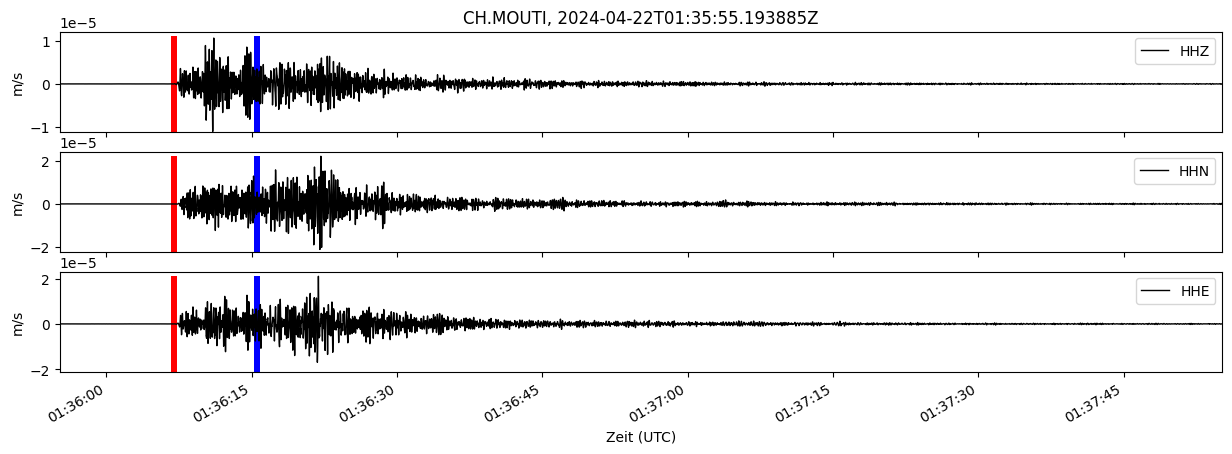

In [42]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

# Find closest CH broadband station:
ch_dist = []
if len(rs_station)<3:
  for idx,sta in enumerate(inv_ch[0]):
    sta_ch_lat = sta.latitude
    sta_ch_lon = sta.longitude
    ch_dist.append(gps2dist_azimuth(sta_ch_lat, sta_ch_lon, sta_lat, sta_lon)[0]/1000)
  nearest_sta = inv_ch[0][np.argmin(ch_dist)].code
  sta_ch_lat = inv_ch[0][np.argmin(ch_dist)].latitude
  sta_ch_lon = inv_ch[0][np.argmin(ch_dist)].longitude
else:
   nearest_sta = rs_station[2]
   inv = Client("ETH").get_stations(network="CH", station=rs_station[2],
                                        location="--", channel="HH*", level="RESP", starttime=origin_time, endtime=origin_time+24*60*60)
   sta_ch_lat = inv[0][0].latitude
   sta_ch_lon = inv[0][0].longitude
   ch_dist.append(gps2dist_azimuth(sta_ch_lat, sta_ch_lon, sta_lat, sta_lon)[0]/1000)
epi_dist_ch = (gps2dist_azimuth(eq_lat, eq_lon, sta_ch_lat, sta_ch_lon)[0]/1000)
print("Die nächste Breitband-Station ist CH." + nearest_sta + ". Sie ist " +str(round(min(ch_dist)*10)/10) + " km von " + rs_station[0] + " entfernt.")


# Theoretical phase arrivals:
if epi_dist_ch <=110:
  phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist_ch/111.111,phase_list=["p","s"])
  p_arr = phase_arrivals[0].time
  s_arr = phase_arrivals[1].time
elif not model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist_ch/111.111,phase_list=["P"]) == []:
  phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist_ch/111.111,phase_list=["P"])
  p_arr = phase_arrivals[0].time
  phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist_ch/111.111,phase_list=["S"])
  s_arr = phase_arrivals[0].time

else:
  phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist_ch/111.111)
  p_arr = phase_arrivals[0].time
  s_arr = []



try:
  stream = Client("ETH").get_waveforms(network="CH", station=nearest_sta, location="--", channel="HH*", starttime = timewindow_start - 60, endtime = timewindow_end + 60, attach_response = True)
  stream.merge(method=0, fill_value='interpolate')
  stream.detrend()
  stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
  stream.remove_response(output='VEL', taper = True)
  stream.trim(starttime = timewindow_start, endtime = timewindow_end)

  fig = plt.figure()
  for idx, trace in enumerate(stream):
    if trace.stats.channel == "HHZ":
      ax = fig.add_subplot(len(stream),1,1)
      plt.title("CH." + nearest_sta+ ", " + str(cat[0].origins[0].time))
    elif trace.stats.channel == "HHN":
      ax = fig.add_subplot(len(stream),1,2)
    else:
      ax = fig.add_subplot(len(stream),1,3)
    ax.xaxis_date()
    ax.plot(trace.times("matplotlib"), trace.data, "k-", linewidth = 1, label = trace.stats.channel)
    plt.bar(origin_time + p_arr, height =  2 * np.abs(trace.max()), bottom = -np.abs(trace.max()), width = (timewindow_end-timewindow_start)/200, align = "center", color = "r")
    if not s_arr == []:
      plt.bar(origin_time + s_arr, height = 2 * np.abs(trace.max()), bottom = -np.abs(trace.max()), width = (timewindow_end-timewindow_start)/200, align = "center", color = "b")
    plt.xlim(timewindow_start, timewindow_end)
    plt.xlabel('Zeit (UTC)')
    plt.ylabel('m/s')
    plt.legend()
    fig.autofmt_xdate()
    fig.set_figheight(5)
    fig.set_figwidth(15)
except:
  print("Ich haben leider keine Daten gefunden. Aendere die Parameter und versuche es noch einmal.")

**SCHRITT 4: Seismogramme von allen seismo-at-school RaspberryShake**

Führe den Code in der nächsten Zelle aus, um die Seismogramme von allen seismo-at-school RaspberryShake in der Schweiz zu sehen.

Ich habe keine Seismogramme für KKNZH gefunden.
Ich habe keine Seismogramme für KSUSZ gefunden.


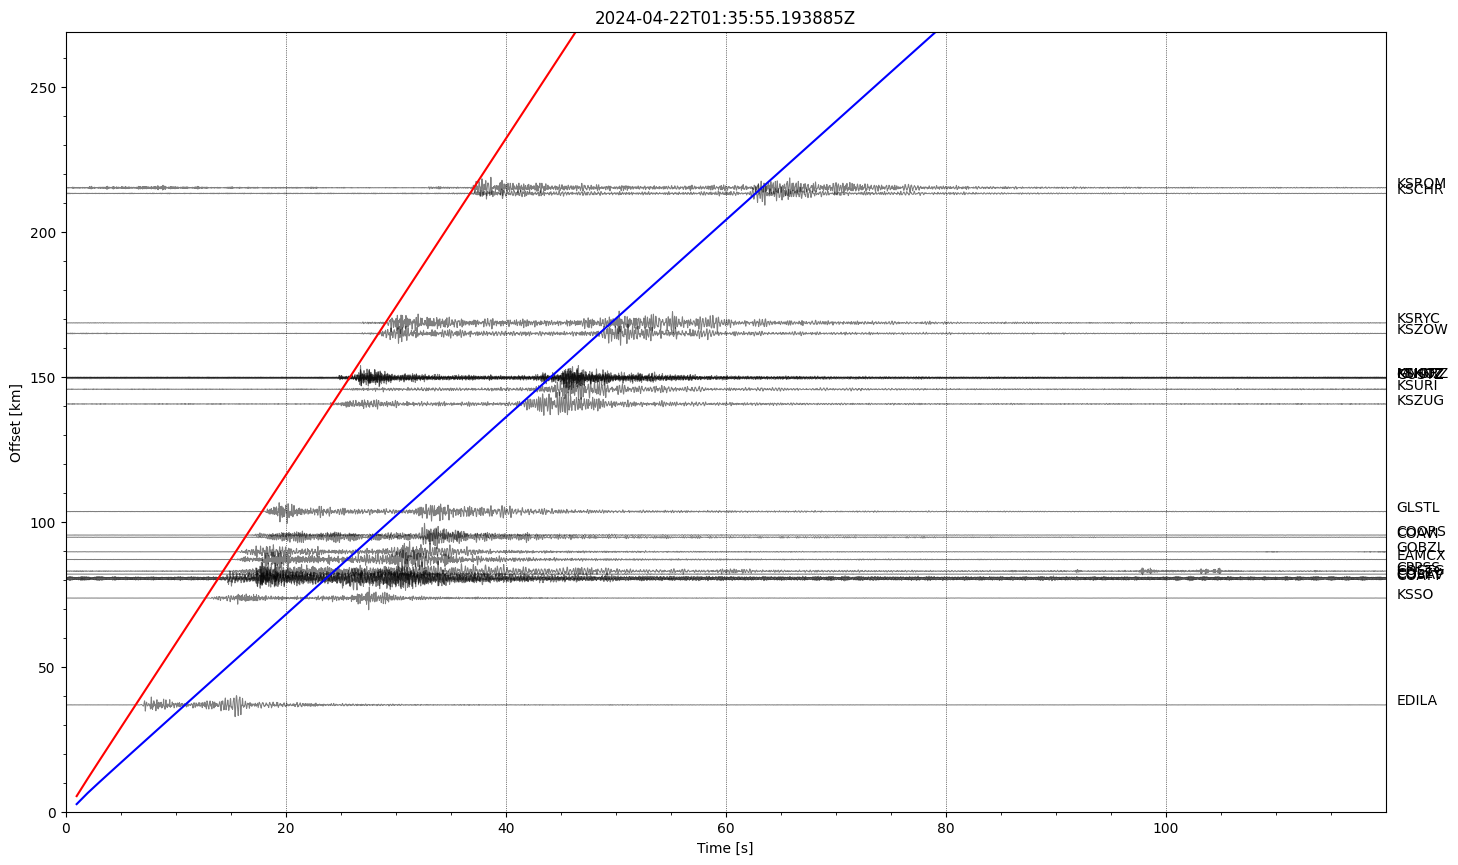

In [43]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:


try:
  for network in ["S"]:
    if network == "CH":
      inventory = inv_ch
    else:
      inventory = inv_s
    stream = Stream()
    distance = []
    name = []
    for idx, inv in enumerate(inventory[0]):
      try:
        station = inv.code
        trace = Client("ETH").get_waveforms(network=network, station=station, location="--",
                                            channel="*Z", starttime=origin_time -60, endtime=timewindow_end +60, attach_response=True)
        trace.merge()
        distance.append(gps2dist_azimuth(inv.latitude, inv.longitude, eq_lat, eq_lon)[0])
        name.append(station)
        stream += trace
      except:
        print("Ich habe keine Seismogramme für " +str(station) + " gefunden.")

    stream.remove_response(output='VEL')
    stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
    stream.trim(starttime = origin_time, endtime = timewindow_end)

    for idx, trace in enumerate(stream):
      trace.stats.distance = distance[idx]
      trace.stats.station = name[idx]

    fig = plt.figure()
    stream.plot(type='section', orientation='horizontal', right_vertical_labels=True,
                linewidth=.75, grid_linewidth=.5, scale=0.75, show=True, fig=fig,
                localization_dict={'Time [s]': 'Zeit [s]', 'Offset [km]': 'Entfernung [km]'})
    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.title(str(cat[0].origins[0].time))

    if min(distance)/1000 < 150:
      time_axis = np.arange(0, int(timewindow_end-origin_time), 1)
      plt.plot(time_axis,np.sqrt(pow(time_axis * vp,2)-pow(eq_depth,2)),'r') # P-wave
      plt.plot(time_axis,np.sqrt(pow(time_axis * vs,2)-pow(eq_depth,2)),'b') # S-wave
      plt.ylim(0,max(distance) /1000 * 1.25)
    else:
      dist_axis = np.arange(int(min(distance)/1000-50), int(max(distance)/1000+50), 50)
      p_arr = []
      s_arr = []

      for dist in dist_axis:
        if not model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=dist/111.111,phase_list=["P"]) == []:
          phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=dist/111.111,phase_list=["P"])
          p_arr.append([phase_arrivals[0].time, dist])
          phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=dist/111.111,phase_list=["S"])
          s_arr.append([phase_arrivals[0].time, dist])
        else:
          phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                         distance_in_degree=dist/111.111)
          p_arr.append([phase_arrivals[0].time, dist])
          s_arr.append([[], dist])

      plt.plot(np.array(p_arr)[:,0],np.array(p_arr)[:,1],'r-') # P-wave
      if not np.array(s_arr)[0,0] == []:
        plt.plot(np.array(s_arr)[:,0],np.array(s_arr)[:,1],'b-') # S-wave

    for idx, trace in enumerate(stream):
      plt.text((timewindow_end - origin_time)+1, trace.stats.distance /1000, str(trace.stats.station))


except:
  print("Ich habe leider keine Daten gefunden.")

**SCHRITT 5: Wellenausbreitung durch das Erdinnere**

Führe den Code in der nächsten Zelle aus, um zu sehen, welchen Weg die schnellsten Erdbebenwellen, die P-Wellen, vom Erdbeben (Stern) bis zu dem RaspberryShake (Dreieck) durch das Erdinnere zurückgelegt haben.

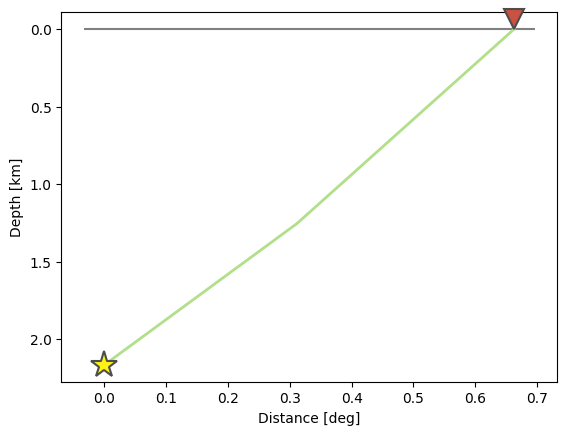

Neben den direkten P- und S-Wellen gibt es noch viele weitere Erdbebenwellen-Phasen, die durch Refraktion und Reflektion von P- und S-Wellen enstehen.
Sie breiten sich durch andere Erdschichten aus und erreichen den RasberryShake zu anderen Zeiten.


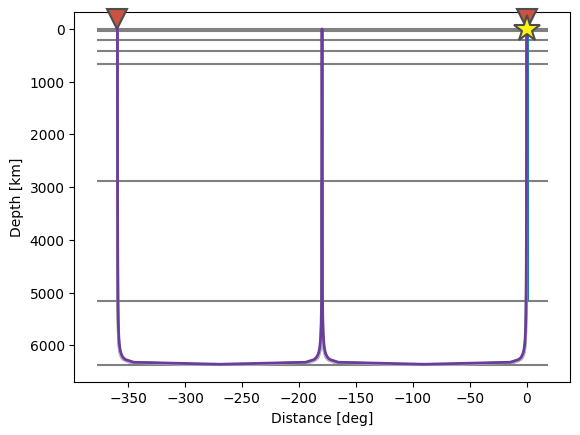

12 arrivals
	p phase arrival at 12.716 seconds
	sP phase arrival at 13.238 seconds
	s phase arrival at 21.951 seconds
	PcP phase arrival at 510.915 seconds
	ScP phase arrival at 722.799 seconds
	ScS phase arrival at 934.958 seconds
	PKiKP phase arrival at 994.200 seconds
	pPKiKP phase arrival at 994.946 seconds
	sPKiKP phase arrival at 995.218 seconds
	PKIKKIKP phase arrival at 1912.524 seconds
	SKIKKIKP phase arrival at 2124.401 seconds
	PKIKPPKIKP phase arrival at 2423.790 seconds
Durch das Picken verschiedener Phasen für viele Erdbeben können Seismologen und Seismologinnen die Geschwindigkeiten verschiedener Gesteinsschichten und den Aufbau der Erde bestimmen.


In [44]:
# @title
# Diesen Code solltest Du nicht verändern:

arrivals = model.get_ray_paths(source_depth_in_km=max([1.0, eq_depth]), distance_in_degree=epi_dist/111.111, phase_list=[phase_arrivals[0].name])
if type == "local":
  ax = arrivals.plot_rays(plot_type="cartesian")
else:
  ax = arrivals.plot_rays()

print("Neben den direkten P- und S-Wellen gibt es noch viele weitere Erdbebenwellen-Phasen, die durch Refraktion und Reflektion von P- und S-Wellen enstehen.")
print("Sie breiten sich durch andere Erdschichten aus und erreichen den RasberryShake zu anderen Zeiten.")
arrivals = model.get_ray_paths(source_depth_in_km=max([1.0, eq_depth]), distance_in_degree=epi_dist/111.111, phase_list=["ttbasic"])
if type == "local":
  ax = arrivals.plot_rays(plot_type="cartesian")
else:
  ax = arrivals.plot_rays()
print(arrivals)
print("Durch das Picken verschiedener Phasen für viele Erdbeben können Seismologen und Seismologinnen die Geschwindigkeiten verschiedener Gesteinsschichten und den Aufbau der Erde bestimmen.")
